<a href="https://colab.research.google.com/github/adityas1998/LIF-Spectra-classification/blob/master/LIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIF Specta Analysis and classification**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
import tensorflow as tf
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os

In [0]:
#Getting links to all file paths
def datasets():
    path = os.curdir
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r, file))
    return files

In [0]:
#making dataframes out of all the given datasets for ease of access
def gen_data_frame():
    main_df=pd.DataFrame()
    label_dict={}
    frames=[]
    files=datasets()
    count=0
    for i in files:
        count+=1
        file=open(i,'r')
        filename=i.split("-")[7]
        data=file.read()
        data_manipulation_step1=data.split("\n")
        data_manipulation_step2=[i.split("\t") for i in data_manipulation_step1]
        df=pd.DataFrame(data_manipulation_step2[0:len(data_manipulation_step2)-1],columns=['A','B','C','D','E','F','G','H'])
        df['id']=count
        frames.append(df)  
        label_dict[count]=filename
    main_df=pd.concat(frames)
    return (main_df,frames,label_dict)

In [0]:
#creating instances of the dataframe/s
df,sub_dfs,lab=gen_data_frame()
lab

{1: 'Kerosene',
 2: 'Petrol25Diesel75',
 3: 'Petrol',
 4: 'Water',
 5: 'Urea',
 6: 'Petrol50Diesel50',
 7: 'MixWaterSugar'}

In [0]:
#checking sub frames
sub_dfs[5]

,A,B,C,D,E,F,G,H,id
0,248.998,-0.000,-0.004,1494.000,1509.000,1509.000,1490.000,1490.000,6
1,249.042,-0.000,-0.016,693.000,698.000,698.000,1490.000,1490.000,6
2,249.086,-0.000,-0.034,695.000,700.000,700.000,693.000,693.000,6
3,249.130,-0.001,-0.056,706.000,708.000,708.000,710.000,710.000,6
4,249.173,-0.003,-0.077,1171.000,1162.000,1162.000,1178.000,1178.000,6
5,249.217,-0.005,-0.097,1312.000,1330.000,1330.000,1315.000,1315.000,6
6,249.261,-0.009,-0.131,1528.000,1561.000,1561.000,1537.000,1537.000,6
7,249.304,-0.014,-0.180,1472.000,1455.000,1455.000,1462.000,1462.000,6
8,249.348,-0.020,-0.226,1117.000,1120.000,1120.000,1103.000,1103.000,6
9,249.392,-0.029,-0.262,1106.000,1083.000,1083.000,1086.000,1086.000,6


In [0]:
#processing the data to make it suitable for using it as an input for the neural network
train=[]
for df_ in sub_dfs:
  feature=np.array(df_['C'])
  train.append(feature)

labels=np.array([1,2,3,4,5,6,7])


In [0]:
def custom_normalizer(test_input,flag="train"):
  test_input=np.array(list(map(float,test_input)))
  test_input=test_input-test_input.mean()
  test_input=test_input/test_input.max()
  if flag=="test":
    test_input=test_input.reshape(1,-1)
  return test_input


In [0]:
normalized_input=[]
for train_input in train:
  normalized=custom_normalizer(train_input)
  normalized_input.append(np.array(normalized))

In [0]:
normalized_input[3]

array([-0.04551877, -0.0454949 , -0.04549968, ..., -0.02479137,
       -0.02485344, -0.02492029])

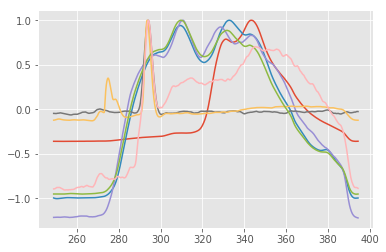

In [0]:
#Plotting all the spectrums 
from matplotlib import style
style.use('ggplot')
plt.plot(np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[0],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[1],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[2],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[3],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[4],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[5],
         np.array(list(map(float,sub_dfs[0]['A']))),normalized_input[6])

In [0]:
#SVM classifier with one label
from sklearn.svm import SVC

labels_=labels.reshape(-1,1)
model=SVC()


model.fit(normalized_input,labels_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
testcase=2
test=sub_dfs[testcase-1]['B']
test=custom_normalizer(test,"test")
predicted_label=model.predict(test)
print("Actual label:",lab[testcase])
print("Predicted label:",lab[predicted_label.item()])

Actual label: Petrol25Diesel75
Predicted label: Petrol25Diesel75
